In [0]:
#pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [0]:
#import external libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import math
%matplotlib inline

In [8]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(device)

True
True
cuda


In [0]:
input_folder_path = "/content/drive/My Drive/Data Set/"
train_df = pd.read_csv(input_folder_path+"train.csv")
test_df = pd.read_csv(input_folder_path+"test.csv")

In [0]:
train_labels = train_df['label'].values
train_images = (train_df.iloc[:,1:].values).astype('float32')
test_images = (test_df.iloc[:,:].values).astype('float32')

In [0]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, stratify=train_labels, random_state=123, test_size=0.20)

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28)
val_images = val_images.reshape(val_images.shape[0], 28, 28)
test_images = test_images.reshape(test_images.shape[0], 28, 28)

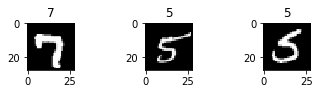

In [13]:
for i in range(106, 109):
    plt.subplot(330 + (i+1))
    plt.imshow(train_images[i], cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

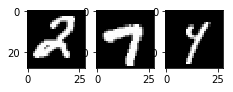

In [14]:
for i in range(26, 29):
    plt.subplot(330 + (i+1))
    plt.imshow(test_images[i].squeeze(), cmap=plt.get_cmap('gray'))

In [0]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

#val
val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)

#test
test_images_tensor = torch.tensor(test_images)/255.0

In [0]:
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)

In [0]:
val_loader = DataLoader(val_tensor, batch_size=16, num_workers=2, shuffle=True)

In [0]:
test_loader = DataLoader(test_images_tensor, batch_size=16, num_workers=2, shuffle=False)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


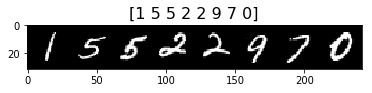

In [19]:
for batch_idx, (data, target) in enumerate(train_loader):
    img_grid = make_grid(data[0:8,].unsqueeze(1), nrow=8)
    img_target_labels = target[0:8,].numpy()
    break
    
plt.imshow(img_grid.numpy().transpose((1,2,0)))
plt.rcParams['figure.figsize'] = (10, 2)
plt.title(img_target_labels, size=16)
plt.show()

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

In [21]:
conv_model = Net()
conv_model

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
  

In [0]:
optimizer = optim.Adam(params=conv_model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    conv_model = conv_model.cuda()
    criterion = criterion.cuda()

In [0]:
def train_model(num_epoch):
    conv_model.train()
    exp_lr_scheduler.step()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        optimizer.zero_grad()
        output = conv_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                num_epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))
            

In [0]:
def evaluate(data_loader):
    conv_model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = conv_model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).data

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [25]:
num_epochs = 25

for n in range(num_epochs):
    train_model(n)
    evaluate(val_loader)

Train Epoch: 0 [1600/33600 (5%)]	Loss: 1.007431
Train Epoch: 0 [3200/33600 (10%)]	Loss: 0.500019
Train Epoch: 0 [4800/33600 (14%)]	Loss: 0.921573
Train Epoch: 0 [6400/33600 (19%)]	Loss: 1.280389
Train Epoch: 0 [8000/33600 (24%)]	Loss: 0.590223
Train Epoch: 0 [9600/33600 (29%)]	Loss: 0.391682
Train Epoch: 0 [11200/33600 (33%)]	Loss: 0.386440
Train Epoch: 0 [12800/33600 (38%)]	Loss: 0.558033
Train Epoch: 0 [14400/33600 (43%)]	Loss: 0.062788
Train Epoch: 0 [16000/33600 (48%)]	Loss: 0.443590
Train Epoch: 0 [17600/33600 (52%)]	Loss: 0.209644
Train Epoch: 0 [19200/33600 (57%)]	Loss: 0.373792
Train Epoch: 0 [20800/33600 (62%)]	Loss: 0.644702
Train Epoch: 0 [22400/33600 (67%)]	Loss: 0.148443
Train Epoch: 0 [24000/33600 (71%)]	Loss: 0.979266
Train Epoch: 0 [25600/33600 (76%)]	Loss: 0.560252
Train Epoch: 0 [27200/33600 (81%)]	Loss: 0.228923
Train Epoch: 0 [28800/33600 (86%)]	Loss: 0.511846
Train Epoch: 0 [30400/33600 (90%)]	Loss: 0.112271
Train Epoch: 0 [32000/33600 (95%)]	Loss: 0.223381
Train E

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Val Loss: 0.0626, Val Accuracy: 8253/8400 (98.000%)

Train Epoch: 1 [1600/33600 (5%)]	Loss: 0.122161
Train Epoch: 1 [3200/33600 (10%)]	Loss: 0.854534
Train Epoch: 1 [4800/33600 (14%)]	Loss: 0.064457
Train Epoch: 1 [6400/33600 (19%)]	Loss: 0.039919
Train Epoch: 1 [8000/33600 (24%)]	Loss: 0.064947
Train Epoch: 1 [9600/33600 (29%)]	Loss: 0.228423
Train Epoch: 1 [11200/33600 (33%)]	Loss: 0.353575
Train Epoch: 1 [12800/33600 (38%)]	Loss: 0.150201
Train Epoch: 1 [14400/33600 (43%)]	Loss: 0.261913
Train Epoch: 1 [16000/33600 (48%)]	Loss: 0.538308
Train Epoch: 1 [17600/33600 (52%)]	Loss: 0.140236
Train Epoch: 1 [19200/33600 (57%)]	Loss: 0.129935
Train Epoch: 1 [20800/33600 (62%)]	Loss: 0.277349
Train Epoch: 1 [22400/33600 (67%)]	Loss: 0.291613
Train Epoch: 1 [24000/33600 (71%)]	Loss: 0.028287
Train Epoch: 1 [25600/33600 (76%)]	Loss: 0.357403
Train Epoch: 1 [27200/33600 (81%)]	Loss: 0.115038
Train Epoch: 1 [28800/33600 (86%)]	Loss: 0.032310
Train Epoch: 1 [30400/33600 (90%)]	Loss: 0.03

In [0]:
def make_predictions(data_loader):
    conv_model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = conv_model(data)
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

In [0]:
test_set_preds = make_predictions(test_loader)

In [0]:
submission_df = pd.read_csv("/content/drive/My Drive/Data Set/sample_submission.csv")

In [29]:
submission_df['Label'] = test_set_preds.numpy().squeeze()
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [0]:
submission_df.to_csv('submission.csv', index=False)

Achieved an accuracy of 0.99271% on Kaggle